In [17]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import healpy as hp
from scipy import integrate
from tqdm.notebook import tqdm

import jax.numpy as jnp
from jax import jit, vmap

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('matplotlibrc')
#mpl.use('macOsX')

## 1. Gas density map

In [69]:
NSIDE = 256
NPIX = hp.nside2npix(NSIDE)
print(f'Angular resolution ~ {hp.nside2resol(NSIDE, arcmin=True):.2f} arcmin')
print(f'Number of pixels: {NPIX}')

co_b_s, l_s = hp.pix2ang(NSIDE, range(NPIX))
b_s = np.pi/2 - co_b_s
lb_s = jnp.dstack((l_s, b_s))[0]

Angular resolution ~ 13.74 arcmin
Number of pixels: 786432


CHIME pixel size ~ 15 arcmin, use NSIDE=256

In [3]:
ds_map = hp.read_map('data/haslam408_ds_Remazeilles2014.fits')
dsds_map = hp.read_map('data/haslam408_dsds_Remazeilles2014.fits')

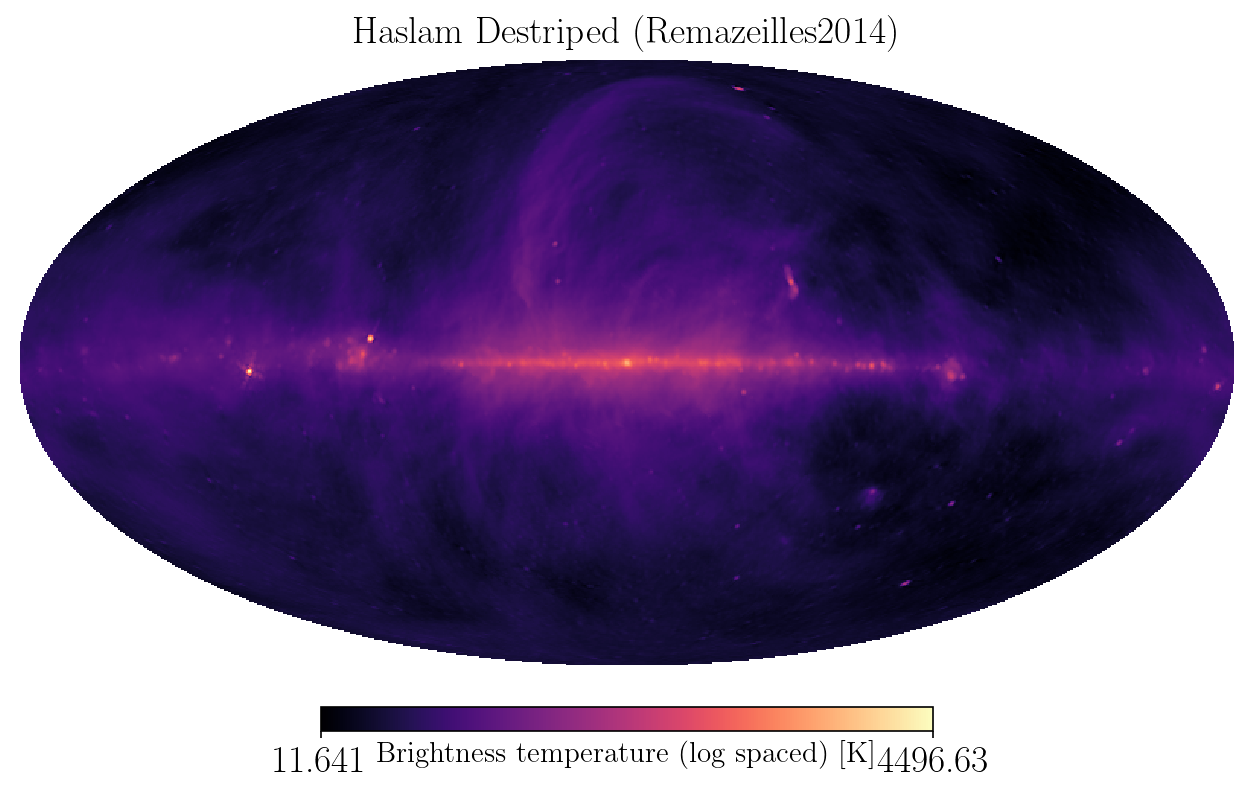

In [4]:
hp.mollview(ds_map, norm='log', title='Haslam Destriped (Remazeilles2014)',
           unit='Brightness temperature (log spaced) [K]', cmap='magma')

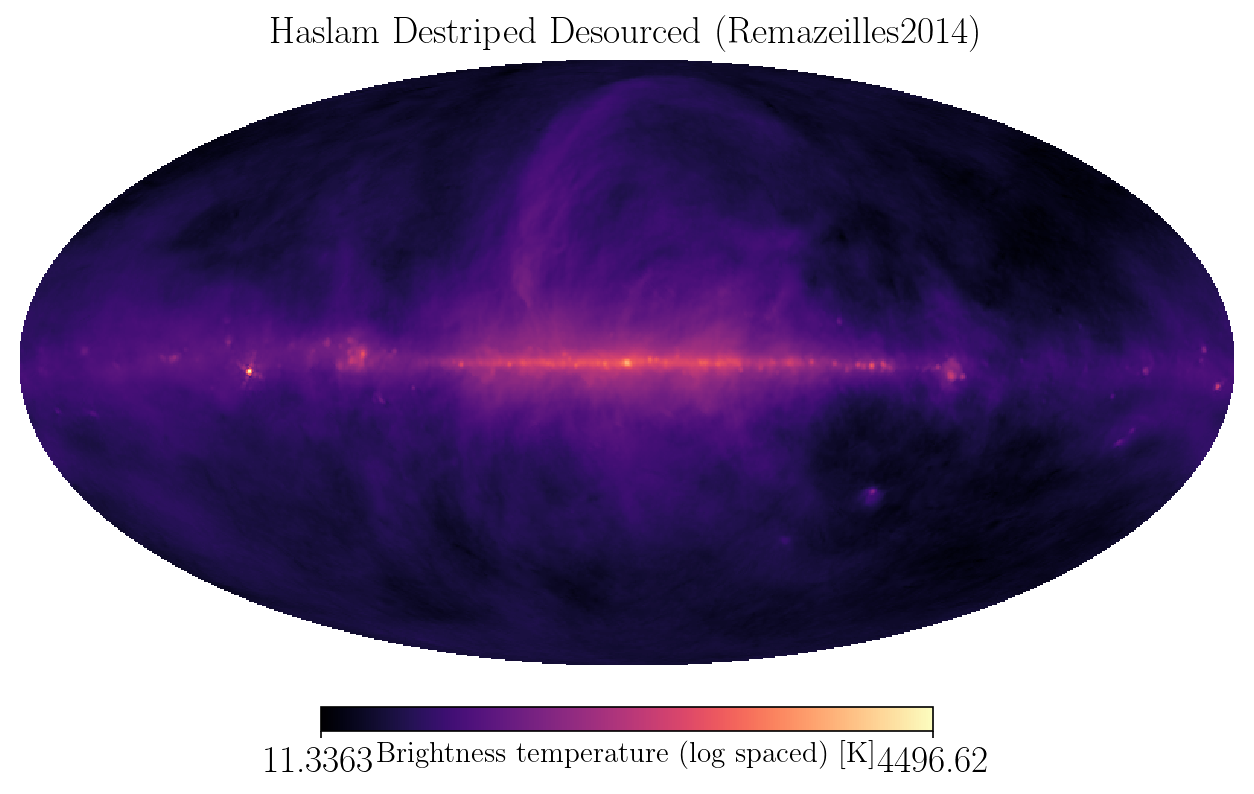

In [5]:
hp.mollview(dsds_map, norm='log', title='Haslam Destriped Desourced (Remazeilles2014)',
           unit='Brightness temperature (log spaced) [K]', cmap='magma')

## 2. DM column integral

In [206]:
rs_NFW = 16 # [kpc]
r_Sun = 8.22 # [kpc]
norm_NFW = 1/( (r_Sun/rs_NFW)*(1+r_Sun/rs_NFW)**2 )

In [211]:
@jit
def rho_NFW(r): # [GeV/cm^3]([kpc])
    return 1/( (r/rs_NFW)*(1+r/rs_NFW)**2 ) / norm_NFW * 0.46
print(rho_NFW(r_Sun), 'GeV/cm^3')

0.45999992 GeV/cm^3


In [212]:
@jit
def r_GC(d, lb): # [kpc]([kpc], [rad], [rad])
    """ Distance to galactic center r as a function of
    d: distance to the Sun
    l: galactic longitude
    b: galactic latitude
    """
    l, b = lb
    x = d*jnp.cos(b)*jnp.cos(l) - r_Sun
    y = d*jnp.cos(b)*jnp.sin(l)
    z = d*jnp.sin(b)
    return jnp.sqrt(x**2+y**2+z**2)

In [213]:
ds = jnp.concatenate((jnp.linspace(0, 20, 200, endpoint=False),
                      jnp.linspace(20, 200, 200, endpoint=False),
                      jnp.linspace(200, 1000, 100, endpoint=True)))
@jit
def rho_integral(lb): # [GeV kpc/cm^3]([rad], [rad], [kpc])
    rhos = rho_NFW(r_GC(ds, lb))
    return jnp.trapz(rhos, ds)

In [214]:
%timeit rho_integral_map = vmap(rho_integral)(lb_s).block_until_ready()

310 ms ± 19.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


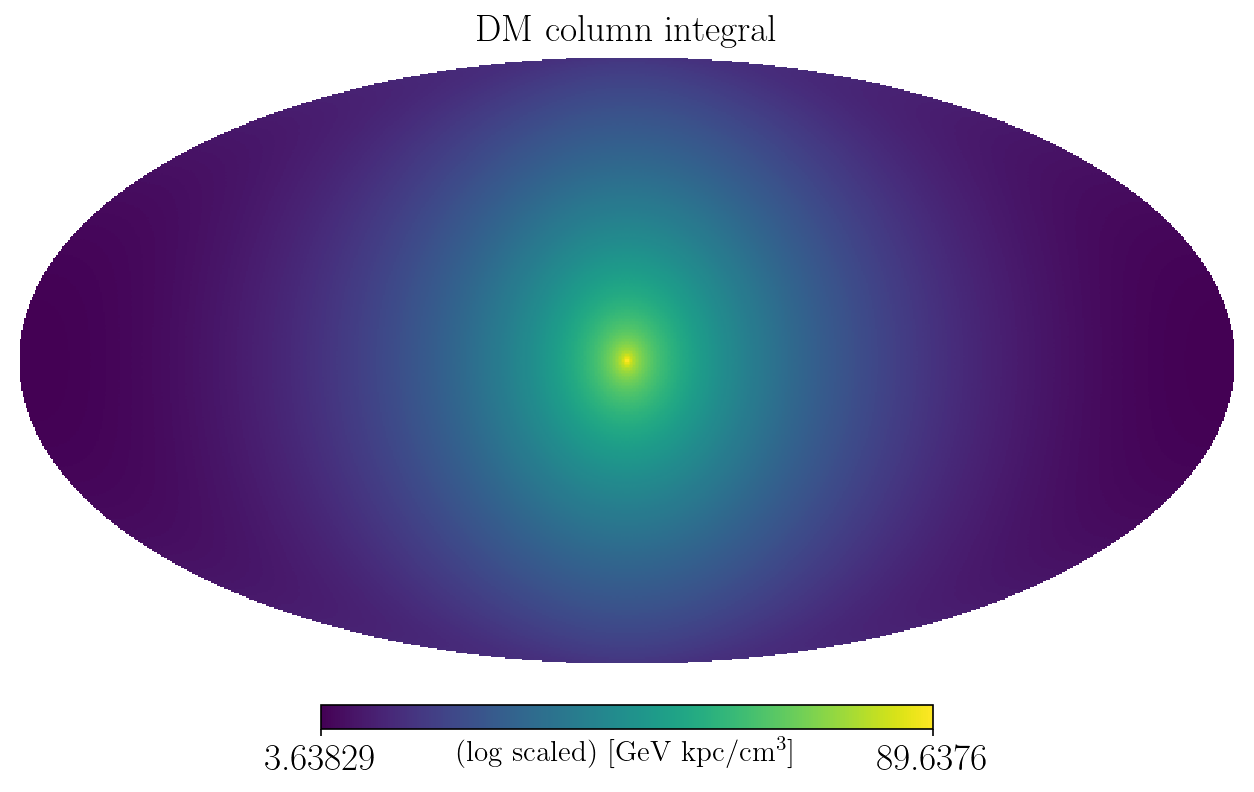

In [81]:
hp.mollview(rho_integral_map, norm='log', title='DM column integral',
            unit='(log scaled) [GeV kpc/cm$^3$]')

## 3. Gegenschein temperature

Gegenschein intensity:
$$I_g=\hbar c^4\frac{g^2}{16}I_{\nu,0}\int\rho.$$
Specific intensity in interested frequency range:
$$I_{\nu,g}=\frac{f_\Delta}{\Delta\nu}\hbar c^4\frac{g^2}{16}I_{\nu,0}\int\rho.$$
Temperature
$$T_g=\frac{f_\Delta}{\Delta\nu}\hbar c^4\frac{g^2}{16}T_0\int\rho.$$
dimensions:
$$\text{[K]}=\frac{[1]}{\text{[MHz]}}\text{[cm}^2\text{ MHz GeV]}(\hbar c^2)\frac{[1]}{\text{[GeV]}^2}\text{[K]}\frac{\text{[GeV]}}{\text{[cm]}^2}(\int\rho c^2).$$

In [82]:
sigma_d = 116/3e5 # km s^-1/km s^-1
fDelta = 0.721 # [1]
Dnu = 2 * sigma_d * 408 # [MHz]
hbarc02 = 5.91571e-10 # [cm^2 MHz GeV]
c0 = 29979.2 # [cm MHz]
kpc = 3.08568e21 # [cm]
gagg = 6.6e-11 # [GeV^-1]

In [83]:
prefac = fDelta/Dnu * hbarc02 * (gagg**2/16) * kpc

In [114]:
# antipodal indices
cob_s, l = hp.pix2ang(NSIDE, range(NPIX))
anti_cob_s = np.pi - cob_s
anti_l_s   = l + np.pi
anti_inds = hp.ang2pix(NSIDE, anti_cob_s, anti_l_s)

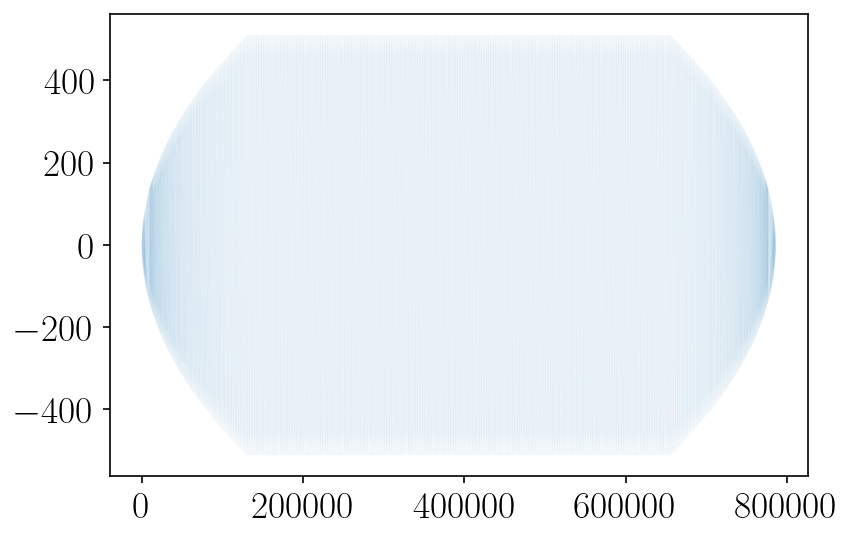

In [115]:
plt.plot(anti_inds - (NPIX-np.arange(NPIX)), linewidth=0.01);

In [127]:
# downsample Haslam map
ds_map_downsample = hp.pixelfunc.ud_grade(ds_map, NSIDE)

# antipodal Haslam map
anti_ds_map = np.zeros_like(ds_map_downsample)
for i, anti_i in enumerate(anti_inds):
    anti_ds_map[anti_i] = ds_map_downsample[i]

# gegenschein temperature
gegen_temp_map = prefac * anti_ds_map * rho_integral_map

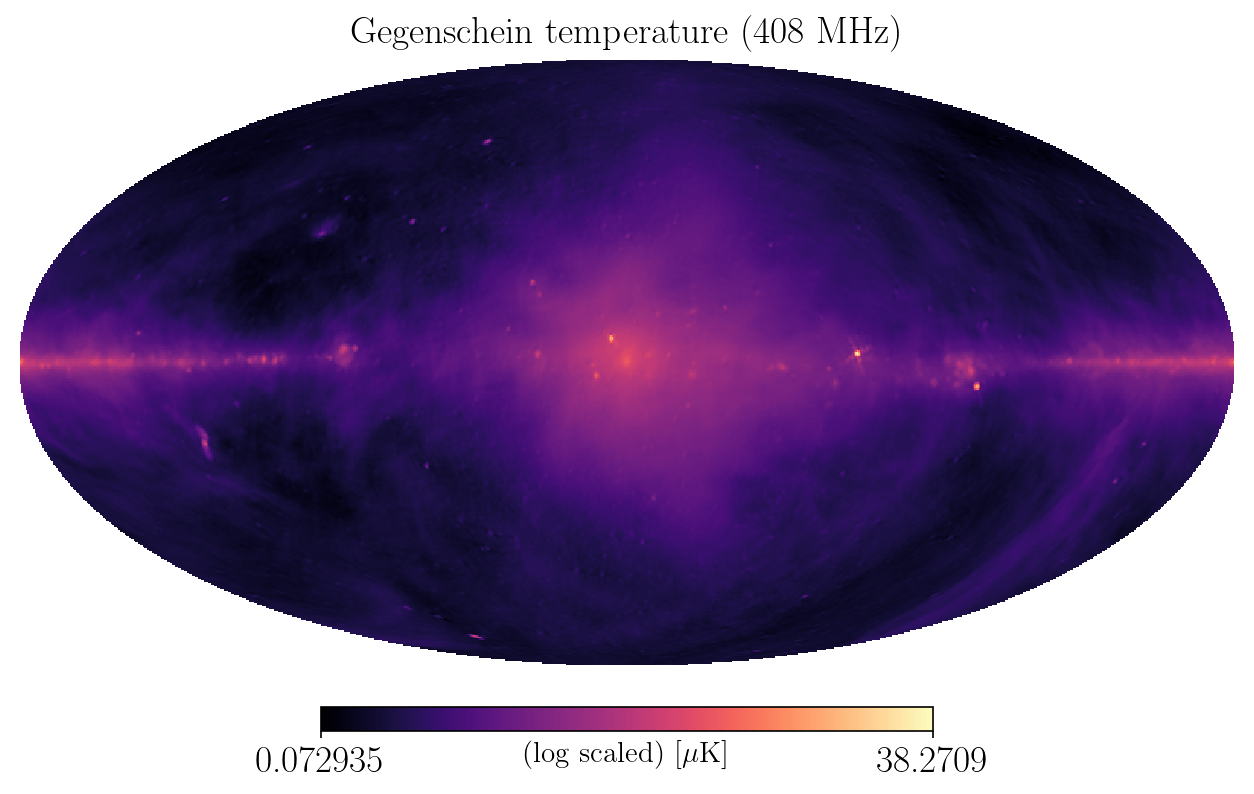

In [151]:
hp.mollview(1e6 * gegen_temp_map, norm='log', cmap='magma',
            title='Gegenschein temperature (408 MHz)', unit='(log scaled) [$\mu$K]')

## 4. Exposure

In [156]:
t_baseline = 600 # [s]
exposure_C = t_baseline / np.abs(np.cos(b_s)) * (b_s > -20*np.pi/180)

In [161]:
# source: https://stackoverflow.com/questions/44443498/how-to-convert-and-save-healpy-map-to-different-coordinate-system
def change_coord(m, coord):
    """ Change coordinates of a HEALPIX map

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

In [158]:
exposure_G = change_coord(exposure_C, ['C', 'G'])

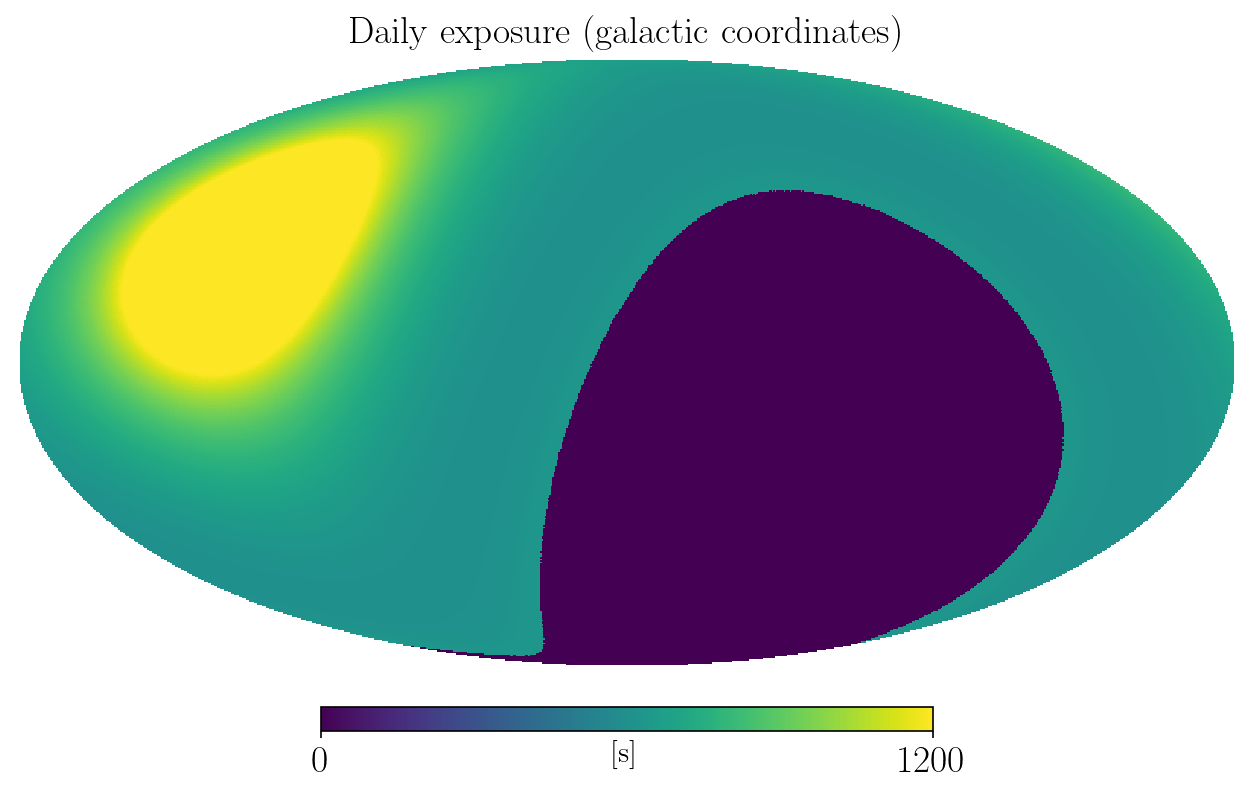

In [160]:
hp.mollview(exposure_G, min=0, max=1200, title='Daily exposure (galactic coordinates)', unit='[s]')

## 5. S/N

$$S/N = \sqrt{\sum_i (S/N_i)^2}$$

$$S/N_i=\frac{T_{g,i}}{T_{\text{sys},i}}\sqrt{2\Delta\nu~t_\text{obs}}$$

In [163]:
# approximate number of CHIME pixels on sky
n_chime_pix = 4*np.pi / ((np.pi/4)*np.deg2rad(15/60)**2)
print(n_chime_pix)

840398.4256030065


In [165]:
NPIX # just use this for now

786432

In [176]:
T_sys_s = np.maximum(np.full_like(ds_map_downsample, 50), ds_map_downsample)
SNR_s = gegen_temp_map * np.sqrt(2*Dnu*1e6*exposure_G*3.5*365.25) / T_sys_s
np.sqrt(np.sum(SNR_s**2))

3.2241383

In [217]:
np.min(SNR_s[SNR_s>0])

DeviceArray(7.217912e-05, dtype=float32)

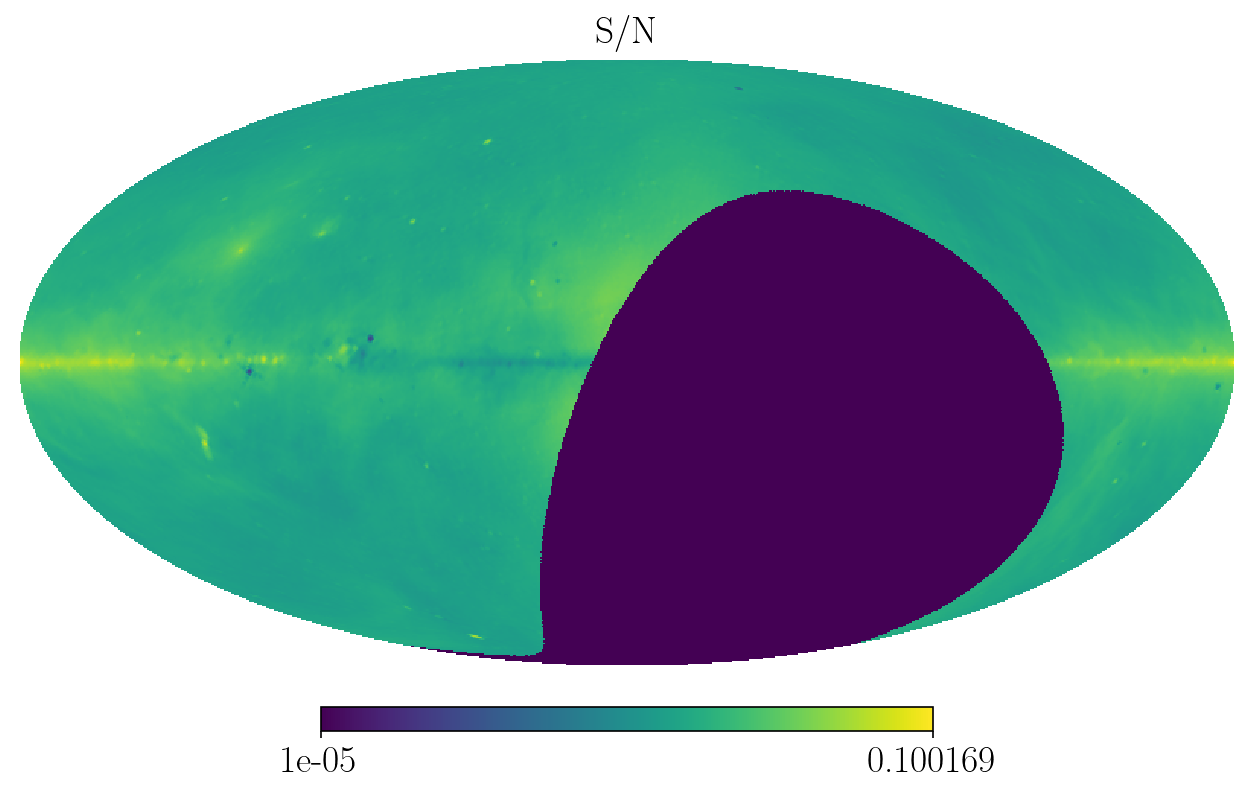

In [221]:
hp.mollview(np.clip(SNR_s, 1e-5, None), title='S/N', norm='log')